# Random Forest classification

A random forest is a machine learning method for classification or regression. This is in a nutshell how it works:
* Many (hundreds or thousands) decision trees are fitted to the training data. Each tree only uses a random subset of the features (e.g. spectral bands).
* In a classification, for each pixel or object, the mode (most frequent value) of the classes is calculated over all individual trees. This is like a majority vote.
* In a regression, for each pixel or object, the mean prediction is calculated over all individual trees.

The file training_lc_Leicester.Geojson in the practicals folder has training areas (polygons) with the following land cover classes:

LandCover:

1 = Water

2 = Residential

3 = Industrial

4 = Pasture

5 = Crops

6 = Bare soil

7 = Forest


First, we import all packages we need and define our directory structure. You can create subdirectories for the image data, training data, model output and classified maps if you like.

In [1]:
# Adapted from: http://remote-sensing.eu/image-classification-with-python/

# import all required Python packages:
import skimage.io as io
import numpy as np
import os, shutil
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.externals import joblib
import matplotlib.pyplot as plt

# set up your directories with the satellite data
rootdir = "/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/"
# path to your training data
path_pix = "/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/"
# path to your model
path_model = "/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/"
# path to your classification results
path_class = "/home/heiko/sf_GY7709_Satellite_Data_Analysis_in_Python/practicals/"

/home/heiko/anaconda3/envs/pyeo_env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Here, we first define a function to read in the raster file with our training data. Each pixel value represents the class of that pixel. This file was created in QGIS with the Vector to Raster conversion tool.

In [24]:
# declare a new function
def training(ntrees = 101):
    # path to your Sentinel-2 TIFF file (here we use a clipped tiff file for faster processing)
    raster = rootdir + "s2a_leicester_clipped.tif"
    # path to your corresponding pixel samples (training data converted to a geotiff raster file)
    # pixel values are the class numbers
    samples = path_pix + "training_raster.tif"  

    # read in clipped Sentinel-2A raster from geotiff (unsigned 16-bit integer format)
    # this was created in QGIS from the original Sentinel-2 10m bands (R,G,B,NIR)
    img_ds = io.imread(raster)
    # convert to 16bit numpy array 
    img = np.array(img_ds, dtype='int16')

    # do the same with your training sample pixels 
    roi_ds = io.imread(samples)   
    roi = np.array(roi_ds, dtype='int8')  
    
    # read in your labels
    labels = np.unique(roi[roi > 0]) 
    print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

    # compose your X,Y data (dataset - training data)     
    X = img[roi > 0, :] 
    Y = roi[roi > 0]     

    # assign class weights (class 1 has the weight 1, etc.)
    weights = {1:1, 2:2, 3:2, 4:1, 5:2, 6:2, 7:2}

    # build your Random Forest Classifier 
    # for more information: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

    rf = RandomForestClassifier(class_weight = weights, n_estimators = ntrees, criterion = 'gini', max_depth = 4, 
                                min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', 
                                bootstrap = True, oob_score = True, n_jobs = 1, random_state = None, verbose = True)  

    # alternatively you may try out a Gradient Boosting Classifier 
    # It is much less RAM consuming and considers weak training data      
    """ 
    rf = GradientBoostingClassifier(n_estimators = ntrees, min_samples_leaf = 1, min_samples_split = 4, max_depth = 4,    
                                    max_features = 'auto', learning_rate = 0.8, subsample = 1, random_state = None,         
                                    warm_start = True)
    """

    # now fit your training data with the original dataset
    rf = rf.fit(X,Y)

    # export your Random Forest / Gradient Boosting Model     
    model = path_model + "model.pkl"
    joblib.dump(rf, model)
    
    # calculate feature importances
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    # Out-of-bag error rate as a function of number of trees:
    oob_error = [] # define an empty list with pairs of values
    
    # Range of `n_estimators` values to explore.
    mintrees = 80 # this needs to be a sensible minimum number to get reliable OOB error estimates
    maxtrees = 150 # go all the way to the highest number of trees
    nsteps = 10 # number of steps to calculate OOB error rate for (saves time)
    
    # work out error rate for each number of trees in the random forest
    for i in range(mintrees, maxtrees + 1, round((maxtrees - mintrees)/nsteps)): # start, end, step
        rf.set_params(n_estimators=i)
        rf.fit(X, Y)
        oob_error.append((i, 1 - rf.oob_score_))

    # Plot OOB error rate vs. number of trees
    xs, ys = zip(*oob_error)
    plt.plot(xs, ys)
    plt.xlim(0, maxtrees)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    #    plt.legend(loc="upper right")
    plt.show()

Now let us execute the function we have just defined.

The training data include 7 classes: [1 2 3 4 5 6 7]


[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   18.5s finished


Feature ranking:
1. feature 2 (0.306579)
2. feature 0 (0.279430)
3. feature 1 (0.241729)
4. feature 3 (0.172263)


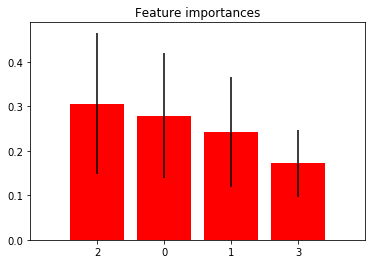

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.6s finished


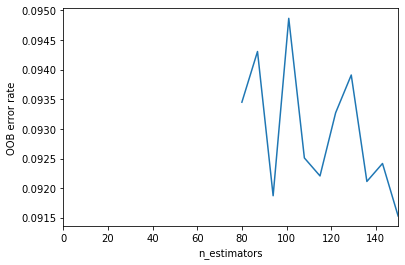

In [25]:
training(ntrees=301)

So far, we have fitted the random forest classification model, assessed which Sentinel-2 bands contribute most to the classification, and looked at how the number of decision trees in the random forest influences the OOB error rate. This is useful to know to see whether the number of trees selected was too low, i.e. the error still decreases a lot when more trees are added.

The next step is to classify the whole Sentinel-2 image extent. Following the same approach as above, we define a function to do the classification, then we execute it.

In [ ]:
def classification():

    # Read Data    
    img_ds = io.imread(raster)   
    img = np.array(img_ds, dtype='int16')    

    # call your random forest model
    rf = path_model + "model.pkl"          
    clf = joblib.load(rf)    

    # Classification of array and save as image (5 refers to the number of bands)
    new_shape = (img.shape[0] * img.shape[1], img.shape[2]) 
    img_as_array = img[:, :, :5].reshape(new_shape)   

    class_prediction = clf.predict(img_as_array) 
    class_prediction = class_prediction.reshape(img[:, :, 0].shape)  

    # now export your classificaiton
    classification = path_class  + "landcover_randomforest.tif" 
    io.imsave(classification, class_prediction)

Now let's run the classification function and see what output we get.

In [ ]:
classification()

# Your portfolio assignment
After running the code above, re-run the random forest model twice:
a) with fewer decision trees
b) with more decision trees
Both times, save the outputs under different filenames.

Take screenshots of the different Random Forest outputs and add them to your portfolio. Write down the reasons for choosing that number of trees in your portfolio.
Add the diagnostic statistics and graphs for both runs.
Show the classified output maps for a selected area of interest and write about 300 words describing the similarities and differences between the two maps.
Identify some interesting features in the maps. You can use arrows to annotate the maps.